In [11]:
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16, ResNet50, MobileNet, InceptionV3, EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import json



In [2]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32

train_dir = "../Dataset_fish_extracted/train"
val_dir = "../Dataset_fish_extracted/val"
test_dir = "../Dataset_fish_extracted/test"

#Training generator with augmentation
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Rescaling the val and test data
val_test_gen = ImageDataGenerator(rescale=1./255)
# Create Generators
train_generator = train_gen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_test_gen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = val_test_gen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 6225 images belonging to 11 classes.
Found 1092 images belonging to 11 classes.
Found 3187 images belonging to 11 classes.


In [3]:
# Saving the class index as json file
class_names = sorted(os.listdir(train_dir))
class_names = [name for name in class_names if os.path.isdir(os.path.join(train_dir, name))]
labels = {i: name for i, name in enumerate(class_names)}

with open('class_labels.json', 'w') as f:
    json.dump(labels, f)

## Model Training

### CUSTOM MADE CNN MODEL

In [4]:
# CNN Model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')  # Output layer
])

c:\sanju\Fish_Image_Classification_Project\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [5]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [7]:
# Train the model
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator
)

Epoch 1/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 513s 3s/step - accuracy: 0.4622 - loss: 1.5798 - val_accuracy: 0.1740 - val_loss: 7.5451
Epoch 2/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 525s 3s/step - accuracy: 0.5899 - loss: 1.2114 - val_accuracy: 0.5000 - val_loss: 2.0230
Epoch 3/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 530s 3s/step - accuracy: 0.6602 - loss: 1.0032 - val_accuracy: 0.8288 - val_loss: 0.6153
Epoch 4/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 583s 3s/step - accuracy: 0.6969 - loss: 0.8941 - val_accuracy: 0.8892 - val_loss: 0.4091
Epoch 5/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 528s 3s/step - accuracy: 0.7399 - loss: 0.7705 - val_accuracy: 0.8718 - val_loss: 0.4497
Epoch 6/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 535s 3s/step - accuracy: 0.7754 - loss: 0.6698 - val_accuracy: 0.8773 - val_loss: 0.4226
Epoch 7/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 514s 3s/step - accuracy: 0.7863 - loss: 0.6418 - val_accuracy: 0.8901 - val_loss: 0.3733
Epoch 8/20
195/195 ━━━━━━━━━━━━━━━━━━━━ 526s 3s/step - accuracy: 0.8173 - loss: 0.5726 - val_accu

In [9]:
#Saving the trained model 
model.save('CustomCNN/custom_cnn.h5')

In [10]:
# Saving the model as keras
model.save('CustomCNN/custom_cnn.keras')

## Working on Pre Trained CNN models

### Model 1: VGG16

In [12]:
# Load pre-trained VGG16

VGG_base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 7s 0us/step


In [13]:
# Modifying the output layer

x = VGG_base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(train_generator.num_classes, activation='softmax')(x)

model_vgg = Model(inputs=VGG_base_model.input, outputs=output)

In [14]:
# Set the whole model as trainable
VGG_base_model.trainable = True

# Freeze all layers except the last 4
for layer in VGG_base_model.layers[:-4]:
    layer.trainable = False

# Compile the model
model_vgg.compile(optimizer=Adam(learning_rate=1e-5),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

In [15]:


# Train the fine tuned VGG16 model

history_vgg_finetune = model_vgg.fit(
    train_generator,
    validation_data=val_generator,
    epochs=5
)



Epoch 1/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 2373s 12s/step - accuracy: 0.3133 - loss: 2.0011 - val_accuracy: 0.7079 - val_loss: 1.3619
Epoch 2/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 2698s 14s/step - accuracy: 0.6072 - loss: 1.1959 - val_accuracy: 0.8214 - val_loss: 0.7490
Epoch 3/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 2559s 13s/step - accuracy: 0.7414 - loss: 0.8234 - val_accuracy: 0.9203 - val_loss: 0.4379
Epoch 4/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 2231s 11s/step - accuracy: 0.8180 - loss: 0.5917 - val_accuracy: 0.9460 - val_loss: 0.3113
Epoch 5/5
195/195 ━━━━━━━━━━━━━━━━━━━━ 1839s 9s/step - accuracy: 0.8654 - loss: 0.4507 - val_accuracy: 0.9570 - val_loss: 0.2385


In [17]:
# Saving the model as h5
model_vgg.save('VGG16/vgg_finetuned_model.h5')



In [18]:
# Saving the model as keras
model_vgg.save('VGG16/vgg_finetuned_model.keras')

### 
Model 2: ResNet50


In [19]:
#creating the base model
resnet_base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step


In [20]:
x = resnet_base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(train_generator.num_classes, activation='softmax')(x)

model_resnet = Model(inputs=resnet_base_model.input, outputs=output)

In [21]:
# Set the whole model as trainable
resnet_base_model.trainable = True

# Freeze all layers except the last 20
for layer in resnet_base_model.layers[:-20]:
    layer.trainable = False

# Compile the model
model_resnet.compile(optimizer=Adam(learning_rate=1e-5),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

In [22]:
# Train the fine-tuned ResNet50 model

history_resnet = model_resnet.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)



Epoch 1/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 708s 4s/step - accuracy: 0.2517 - loss: 2.1663 - val_accuracy: 0.0559 - val_loss: 2.5120
Epoch 2/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 854s 4s/step - accuracy: 0.3974 - loss: 1.7779 - val_accuracy: 0.3617 - val_loss: 2.0790
Epoch 3/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 839s 4s/step - accuracy: 0.4938 - loss: 1.5322 - val_accuracy: 0.6310 - val_loss: 1.3732
Epoch 4/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 891s 5s/step - accuracy: 0.5394 - loss: 1.3672 - val_accuracy: 0.6676 - val_loss: 1.0870
Epoch 5/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 712s 4s/step - accuracy: 0.5831 - loss: 1.2534 - val_accuracy: 0.7088 - val_loss: 0.9791
Epoch 6/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 711s 4s/step - accuracy: 0.6217 - loss: 1.1547 - val_accuracy: 0.7692 - val_loss: 0.8447
Epoch 7/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 710s 4s/step - accuracy: 0.6431 - loss: 1.0827 - val_accuracy: 0.7280 - val_loss: 0.8474
Epoch 8/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 700s 4s/step - accuracy: 0.6647 - loss: 1.0245 - val_accu

In [23]:
# Saving the model as h5
model_resnet.save('ResNet50/resnet_finetuned_model.h5')

In [24]:
# Saving the model as keras
model_resnet.save('ResNet50/resnet_finetuned_model.keras')

### Model 3 - MobileNet

In [25]:
# Load pre-trained MobileNet

mobilenet_base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [26]:
# Modifying the output layer

x = mobilenet_base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(train_generator.num_classes, activation='softmax')(x)

model_mobilenet = Model(inputs=mobilenet_base_model.input, outputs=output)

In [27]:
# Set the whole model as trainable
mobilenet_base_model.trainable = True

# Freeze all layers except the last 30
for layer in mobilenet_base_model.layers[:-30]:
    layer.trainable = False

In [28]:
# Compile the model
model_mobilenet.compile(optimizer=Adam(learning_rate=1e-5),
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])

In [29]:
# Train the fine-tuned MobileNet model

history_mobilenet = model_mobilenet.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

Epoch 1/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 295s 1s/step - accuracy: 0.2900 - loss: 2.2897 - val_accuracy: 0.6813 - val_loss: 1.3343
Epoch 2/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 356s 2s/step - accuracy: 0.5791 - loss: 1.3279 - val_accuracy: 0.8745 - val_loss: 0.7161
Epoch 3/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 329s 2s/step - accuracy: 0.7341 - loss: 0.8869 - val_accuracy: 0.9332 - val_loss: 0.4340
Epoch 4/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 358s 2s/step - accuracy: 0.8170 - loss: 0.6477 - val_accuracy: 0.9551 - val_loss: 0.2905
Epoch 5/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 360s 2s/step - accuracy: 0.8763 - loss: 0.4735 - val_accuracy: 0.9698 - val_loss: 0.2059
Epoch 6/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 329s 2s/step - accuracy: 0.9043 - loss: 0.3749 - val_accuracy: 0.9826 - val_loss: 0.1565
Epoch 7/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 345s 2s/step - accuracy: 0.9282 - loss: 0.2923 - val_accuracy: 0.9872 - val_loss: 0.1251
Epoch 8/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 307s 2s/step - accuracy: 0.9382 - loss: 0.2493 - val_accu

In [30]:
# Saving the model as h5
model_mobilenet.save('MobileNet/mobilenet_finetuned_model.h5')

In [31]:
# Saving the model as keras
model_mobilenet.save('MobileNet/mobilenet_finetuned_model.keras')

### Model 4 - InceptionV3


In [32]:
inception_base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 9s 0us/step


In [33]:
# Modify the output layer

x = inception_base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(train_generator.num_classes, activation='softmax')(x)

model_inception = Model(inputs=inception_base_model.input, outputs=output)

In [ ]:
# Set the whole model as trainable
inception_base_model.trainable = True

# Freeze all layers except the last 50
for layer in inception_base_model.layers[:-50]:
    layer.trainable = False



In [35]:
# Compile the model
model_inception.compile(optimizer=Adam(learning_rate=1e-5),
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])



In [36]:
# Train the fine-tuned InceptionV3

history_inception = model_inception.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

Epoch 1/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 547s 3s/step - accuracy: 0.4477 - loss: 1.7779 - val_accuracy: 0.8581 - val_loss: 0.8972
Epoch 2/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 551s 3s/step - accuracy: 0.7981 - loss: 0.8388 - val_accuracy: 0.9368 - val_loss: 0.3827
Epoch 3/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 467s 2s/step - accuracy: 0.8903 - loss: 0.4814 - val_accuracy: 0.9570 - val_loss: 0.2292
Epoch 4/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 586s 3s/step - accuracy: 0.9161 - loss: 0.3325 - val_accuracy: 0.9689 - val_loss: 0.1589
Epoch 5/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 453s 2s/step - accuracy: 0.9356 - loss: 0.2561 - val_accuracy: 0.9744 - val_loss: 0.1196
Epoch 6/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 442s 2s/step - accuracy: 0.9512 - loss: 0.1953 - val_accuracy: 0.9789 - val_loss: 0.0922
Epoch 7/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 440s 2s/step - accuracy: 0.9558 - loss: 0.1794 - val_accuracy: 0.9844 - val_loss: 0.0738
Epoch 8/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 461s 2s/step - accuracy: 0.9690 - loss: 0.1308 - val_accu

In [37]:
# Saving the model as h5
model_inception.save('InceptionV3/inception_finetuned_model.h5')

In [38]:
# Saving the model as keras
model_inception.save('InceptionV3/inception_finetuned_model.keras')

### 
Model 5: EfficientNetB0


In [39]:
# Load pre-trained EfficientNetB0

efficientnet_base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [40]:
# Modify output layer

x = efficientnet_base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(train_generator.num_classes, activation='softmax')(x)

model_efficientnet = Model(inputs=efficientnet_base_model.input, outputs=output)

In [41]:
# Set the whole model as trainable
efficientnet_base_model.trainable = True

# Freeze all layers except the top 20
for layer in efficientnet_base_model.layers[:-20]:
    layer.trainable = False

In [42]:
# Compile the model
model_efficientnet.compile(optimizer=Adam(learning_rate=1e-5),
                           loss='categorical_crossentropy',
                           metrics=['accuracy'])

In [43]:
# Train the fine-tuned EfficientNetB0


history_efficientnet = model_efficientnet.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

Epoch 1/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 326s 2s/step - accuracy: 0.1296 - loss: 2.3914 - val_accuracy: 0.1035 - val_loss: 2.3743
Epoch 2/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 320s 2s/step - accuracy: 0.1550 - loss: 2.3567 - val_accuracy: 0.1712 - val_loss: 2.3415
Epoch 3/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 428s 2s/step - accuracy: 0.1648 - loss: 2.3455 - val_accuracy: 0.1712 - val_loss: 2.3295
Epoch 4/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 404s 2s/step - accuracy: 0.1569 - loss: 2.3425 - val_accuracy: 0.1712 - val_loss: 2.3263
Epoch 5/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 349s 2s/step - accuracy: 0.1648 - loss: 2.3364 - val_accuracy: 0.1712 - val_loss: 2.3192
Epoch 6/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 344s 2s/step - accuracy: 0.1643 - loss: 2.3350 - val_accuracy: 0.1712 - val_loss: 2.3169
Epoch 7/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 358s 2s/step - accuracy: 0.1639 - loss: 2.3325 - val_accuracy: 0.1712 - val_loss: 2.3161
Epoch 8/10
195/195 ━━━━━━━━━━━━━━━━━━━━ 354s 2s/step - accuracy: 0.1658 - loss: 2.3260 - val_accu

In [44]:
# Saving the model as h5
model_inception.save('EfficientNetB0/efficientnet_finetuned_model.h5')


In [45]:
# Saving the model as keras
model_inception.save('EfficientNetB0/efficientnet_finetuned_model.keras')


## Model Evaluation



### Accuracy


In [46]:
# Computing CNNs Accuracy
cnn_loss, cnn_accuracy = model.evaluate(test_generator)
print(f"Custom CNN Accuracy: {cnn_accuracy:.4f}")

# Computing fine-tuned VGG16s Accuracy
vgg_loss, vgg_accuracy = model_vgg.evaluate(test_generator)
print(f"VGG16 Accuracy: {vgg_accuracy:.4f}")

# Computing fine-tuned ResNet50s Accuracy
resnet_loss, resnet_accuracy = model_resnet.evaluate(test_generator)
print(f"ResNet50 Accuracy: {resnet_accuracy:.4f}")

# Computing fine-tuned MobileNets Accuracy
mobilenet_loss, mobilenet_accuracy = model_mobilenet.evaluate(test_generator)
print(f"MobileNet Accuracy: {mobilenet_accuracy:.4f}")

# Computing fine-tuned InceptionV3 Accuracy
inception_loss, inception_accuracy = model_inception.evaluate(test_generator)
print(f"InceptionV3 Accuracy: {inception_accuracy:.4f}")

# Computing fine-tuned EfficientNetb0 Accuracy
efficient_loss, efficient_accuracy = model_efficientnet.evaluate(test_generator)
print(f"EfficientNetB0 Accuracy: {efficient_accuracy:.4f}")

100/100 ━━━━━━━━━━━━━━━━━━━━ 167s 2s/step - accuracy: 0.9511 - loss: 0.1771
Custom CNN Accuracy: 0.9511
100/100 ━━━━━━━━━━━━━━━━━━━━ 717s 7s/step - accuracy: 0.9602 - loss: 0.2089
VGG16 Accuracy: 0.9602
100/100 ━━━━━━━━━━━━━━━━━━━━ 259s 3s/step - accuracy: 0.7386 - loss: 0.8377
ResNet50 Accuracy: 0.7386
100/100 ━━━━━━━━━━━━━━━━━━━━ 69s 689ms/step - accuracy: 0.9931 - loss: 0.0476
MobileNet Accuracy: 0.9931
100/100 ━━━━━━━━━━━━━━━━━━━━ 169s 2s/step - accuracy: 0.9944 - loss: 0.0256
InceptionV3 Accuracy: 0.9944
100/100 ━━━━━━━━━━━━━━━━━━━━ 85s 852ms/step - accuracy: 0.1632 - loss: 2.3127
EfficientNetB0 Accuracy: 0.1632


### Precision, Recall, and F1-score


In [47]:
# Custom CNN
test_generator.reset()
cnn_prob = model.predict(test_generator, verbose=0)
cnn_pred = np.argmax(cnn_prob, axis=1)
print("=== Custom CNN ===")
print(classification_report(test_generator.classes, cnn_pred, target_names=test_generator.class_indices.keys(), zero_division=0, digits=4))

=== Custom CNN ===
                                  precision    recall  f1-score   support

                     animal fish     0.9755    0.9942    0.9848       520
                animal fish bass     0.0000    0.0000    0.0000        13
   fish sea_food black_sea_sprat     0.9198    1.0000    0.9582       298
   fish sea_food gilt_head_bream     1.0000    0.7574    0.8619       305
   fish sea_food hourse_mackerel     0.9959    0.8566    0.9211       286
        fish sea_food red_mullet     0.9700    1.0000    0.9848       291
     fish sea_food red_sea_bream     0.8318    0.9780    0.8990       273
          fish sea_food sea_bass     0.9088    0.9755    0.9410       327
            fish sea_food shrimp     1.0000    1.0000    1.0000       289
fish sea_food striped_red_mullet     0.9759    0.9693    0.9726       293
             fish sea_food trout     0.9539    0.9932    0.9732       292

                        accuracy                         0.9511      3187
                 

In [48]:
# VGG16
test_generator.reset()
vgg_prob = model_vgg.predict(test_generator, verbose=0)
vgg_pred = np.argmax(vgg_prob, axis=1)
print("=== VGG16 ===")
print(classification_report(test_generator.classes, vgg_pred, target_names=test_generator.class_indices.keys(), zero_division=0, digits=4))

=== VGG16 ===
                                  precision    recall  f1-score   support

                     animal fish     0.9773    0.9942    0.9857       520
                animal fish bass     0.0000    0.0000    0.0000        13
   fish sea_food black_sea_sprat     0.9427    0.9933    0.9673       298
   fish sea_food gilt_head_bream     0.9132    1.0000    0.9546       305
   fish sea_food hourse_mackerel     0.9754    0.9720    0.9737       286
        fish sea_food red_mullet     0.9414    0.8832    0.9113       291
     fish sea_food red_sea_bream     1.0000    0.9377    0.9679       273
          fish sea_food sea_bass     0.9906    0.9694    0.9799       327
            fish sea_food shrimp     0.9698    1.0000    0.9847       289
fish sea_food striped_red_mullet     0.8874    0.8874    0.8874       293
             fish sea_food trout     1.0000    0.9760    0.9879       292

                        accuracy                         0.9602      3187
                      

In [49]:
# ResNet50
test_generator.reset()
resnet_prob = model_resnet.predict(test_generator, verbose=0)
resnet_pred = np.argmax(resnet_prob, axis=1)
print("=== ResNet50 ===")
print(classification_report(test_generator.classes, resnet_pred, target_names=test_generator.class_indices.keys(), zero_division=0, digits=4))

=== ResNet50 ===
                                  precision    recall  f1-score   support

                     animal fish     0.8679    0.9731    0.9175       520
                animal fish bass     0.0000    0.0000    0.0000        13
   fish sea_food black_sea_sprat     0.6800    0.9128    0.7794       298
   fish sea_food gilt_head_bream     0.8767    0.6295    0.7328       305
   fish sea_food hourse_mackerel     0.7158    0.7133    0.7145       286
        fish sea_food red_mullet     0.7435    0.4880    0.5892       291
     fish sea_food red_sea_bream     0.7403    0.9084    0.8158       273
          fish sea_food sea_bass     0.8684    0.6055    0.7135       327
            fish sea_food shrimp     0.4809    0.9585    0.6405       289
fish sea_food striped_red_mullet     0.6299    0.2730    0.3810       293
             fish sea_food trout     0.9671    0.8048    0.8785       292

                        accuracy                         0.7386      3187
                   

In [50]:
# MobileNet
test_generator.reset()
mobilenet_prob = model_mobilenet.predict(test_generator, verbose=0)
mobilenet_pred = np.argmax(mobilenet_prob, axis=1)
print("=== MobileNet ===")
print(classification_report(test_generator.classes, mobilenet_pred, target_names=test_generator.class_indices.keys(), zero_division=0, digits=4))

=== MobileNet ===
                                  precision    recall  f1-score   support

                     animal fish     0.9756    1.0000    0.9877       520
                animal fish bass     0.0000    0.0000    0.0000        13
   fish sea_food black_sea_sprat     0.9967    1.0000    0.9983       298
   fish sea_food gilt_head_bream     1.0000    1.0000    1.0000       305
   fish sea_food hourse_mackerel     1.0000    1.0000    1.0000       286
        fish sea_food red_mullet     0.9863    0.9897    0.9880       291
     fish sea_food red_sea_bream     1.0000    1.0000    1.0000       273
          fish sea_food sea_bass     1.0000    0.9969    0.9985       327
            fish sea_food shrimp     1.0000    1.0000    1.0000       289
fish sea_food striped_red_mullet     0.9863    0.9829    0.9846       293
             fish sea_food trout     1.0000    1.0000    1.0000       292

                        accuracy                         0.9931      3187
                  

In [51]:
# InceptionV3
test_generator.reset()
inception_prob = model_inception.predict(test_generator, verbose=0)
inception_pred = np.argmax(inception_prob, axis=1)
print("=== InceptionV3 ===")
print(classification_report(test_generator.classes, inception_pred, target_names=test_generator.class_indices.keys(), zero_division=0, digits=4))

=== InceptionV3 ===
                                  precision    recall  f1-score   support

                     animal fish     0.9774    0.9981    0.9876       520
                animal fish bass     1.0000    0.0769    0.1429        13
   fish sea_food black_sea_sprat     1.0000    0.9966    0.9983       298
   fish sea_food gilt_head_bream     1.0000    1.0000    1.0000       305
   fish sea_food hourse_mackerel     0.9965    1.0000    0.9983       286
        fish sea_food red_mullet     1.0000    0.9966    0.9983       291
     fish sea_food red_sea_bream     1.0000    1.0000    1.0000       273
          fish sea_food sea_bass     0.9909    1.0000    0.9954       327
            fish sea_food shrimp     1.0000    1.0000    1.0000       289
fish sea_food striped_red_mullet     0.9932    0.9898    0.9915       293
             fish sea_food trout     1.0000    1.0000    1.0000       292

                        accuracy                         0.9944      3187
                

In [52]:
# EfficientNetB0
test_generator.reset()
efficient_prob = model_efficientnet.predict(test_generator, verbose=0)
efficient_pred = np.argmax(efficient_prob, axis=1)
print("=== EfficientNetB0 ===")
print(classification_report(test_generator.classes, efficient_pred, target_names=test_generator.class_indices.keys(), zero_division=0, digits=4))

=== EfficientNetB0 ===
                                  precision    recall  f1-score   support

                     animal fish     0.1632    1.0000    0.2806       520
                animal fish bass     0.0000    0.0000    0.0000        13
   fish sea_food black_sea_sprat     0.0000    0.0000    0.0000       298
   fish sea_food gilt_head_bream     0.0000    0.0000    0.0000       305
   fish sea_food hourse_mackerel     0.0000    0.0000    0.0000       286
        fish sea_food red_mullet     0.0000    0.0000    0.0000       291
     fish sea_food red_sea_bream     0.0000    0.0000    0.0000       273
          fish sea_food sea_bass     0.0000    0.0000    0.0000       327
            fish sea_food shrimp     0.0000    0.0000    0.0000       289
fish sea_food striped_red_mullet     0.0000    0.0000    0.0000       293
             fish sea_food trout     0.0000    0.0000    0.0000       292

                        accuracy                         0.1632      3187
             

### Confusion Matrix


In [53]:
def plot_confusion_matrix(y_true, y_pred, class_names, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=90)
    plt.yticks(tick_marks, class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

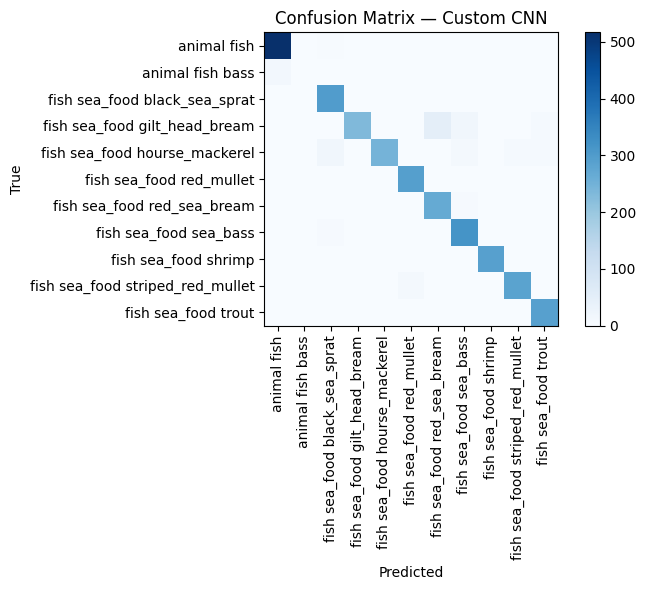

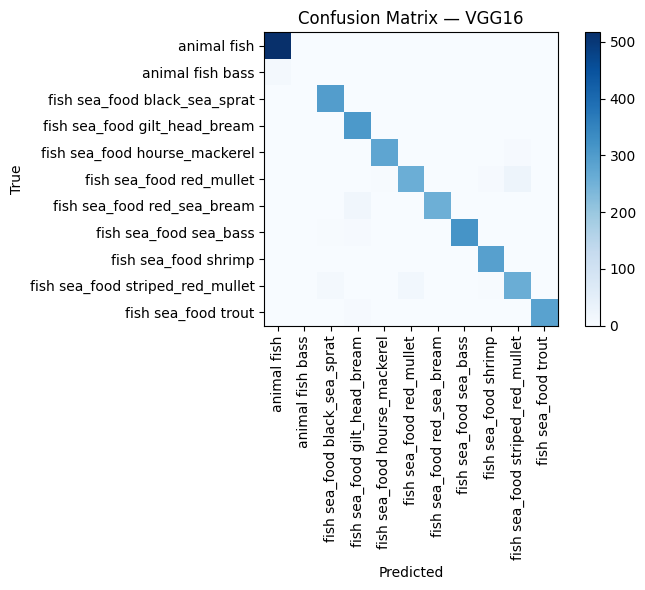

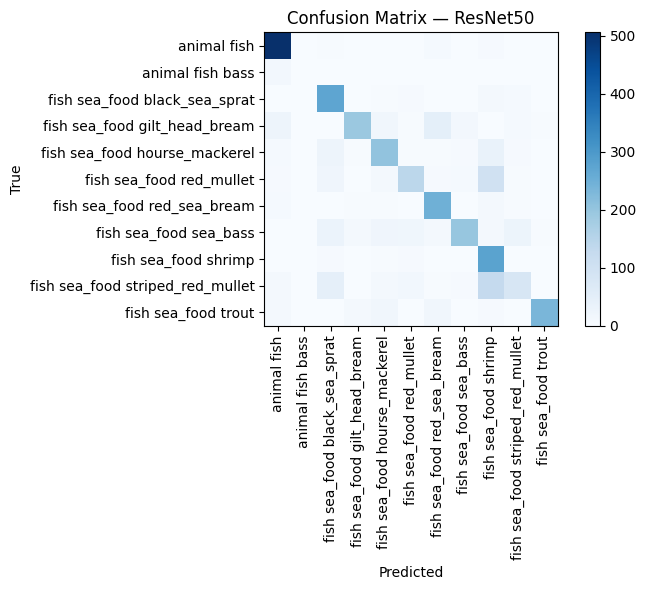

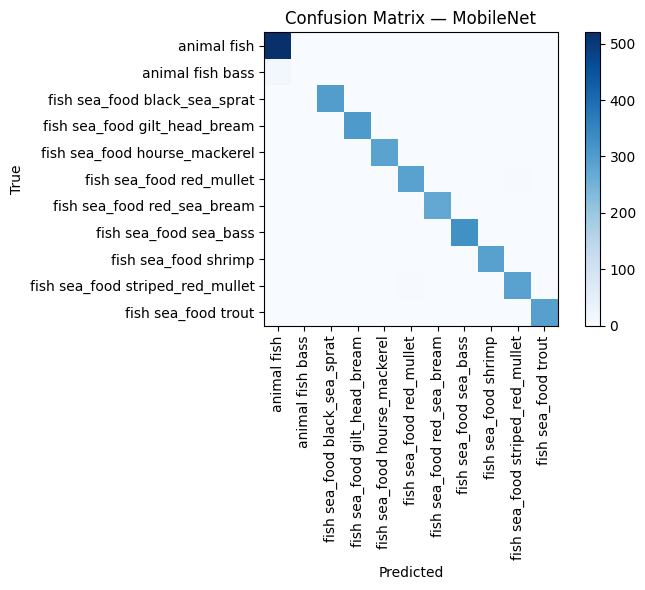

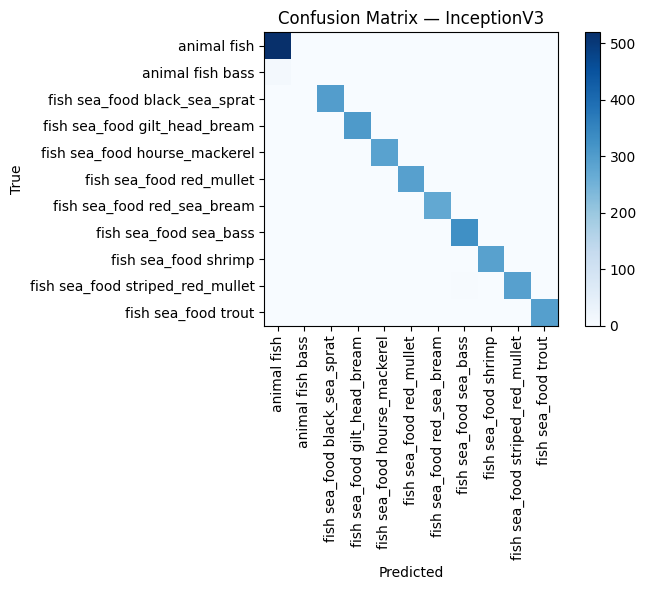

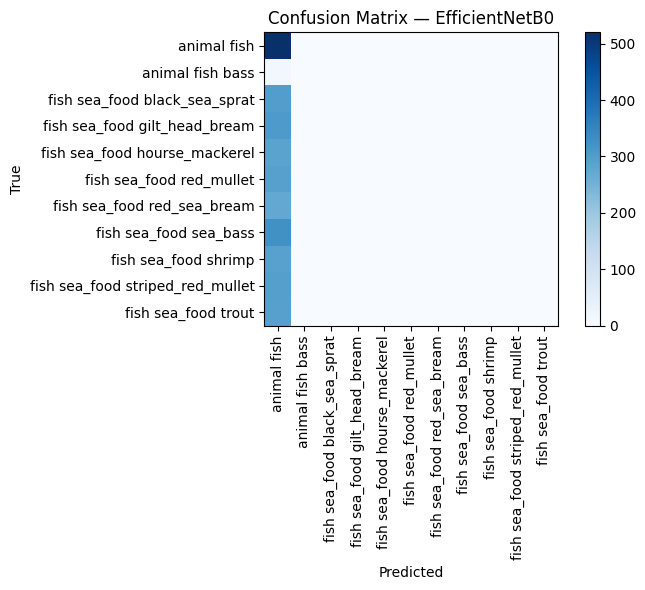

In [54]:
class_names = list(test_generator.class_indices.keys())
y_true = test_generator.classes

# Custom CNN
plot_confusion_matrix(y_true, cnn_pred, class_names, "Confusion Matrix — Custom CNN")

# VGG16
plot_confusion_matrix(y_true, vgg_pred, class_names, "Confusion Matrix — VGG16")

# ResNet50
plot_confusion_matrix(y_true, resnet_pred, class_names, "Confusion Matrix — ResNet50")

# MobileNet
plot_confusion_matrix(y_true, mobilenet_pred, class_names, "Confusion Matrix — MobileNet")

# InceptionV3
plot_confusion_matrix(y_true, inception_pred, class_names, "Confusion Matrix — InceptionV3")

# EfficientNetB0
plot_confusion_matrix(y_true, efficient_pred, class_names, "Confusion Matrix — EfficientNetB0")

### Visualize training history (accuracy and loss) for each model.


In [55]:
histories = [
    ("Custom CNN",             history),                 # e.g., from model.fit(...)
    ("VGG16 (fine-tuned)",     history_vgg_finetune),
    ("ResNet50 (fine-tuned)",  history_resnet),
    ("MobileNet (fine-tuned)", history_mobilenet),
    ("InceptionV3 (fine-tuned)", history_inception),
    ("EfficientNetB0 (fine-tuned)", history_efficientnet),
]

def _get(hist, k1, k2):
    return hist.history.get(k1) or hist.history.get(k2)

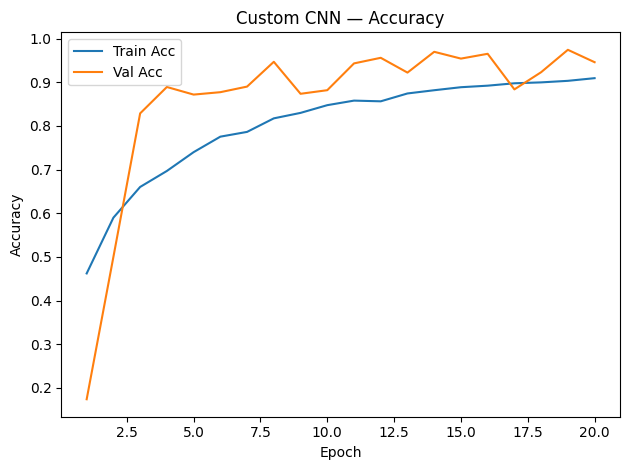

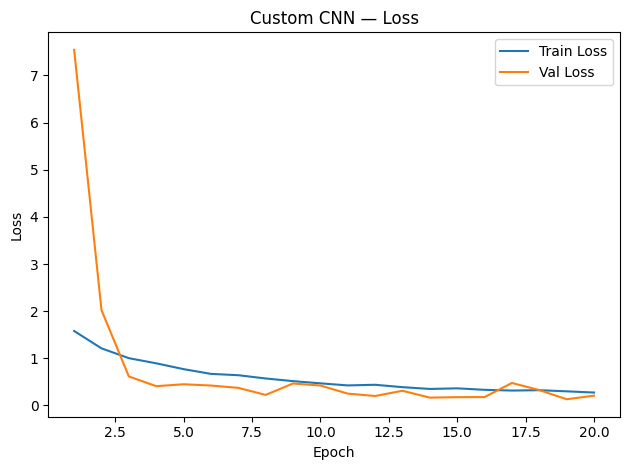

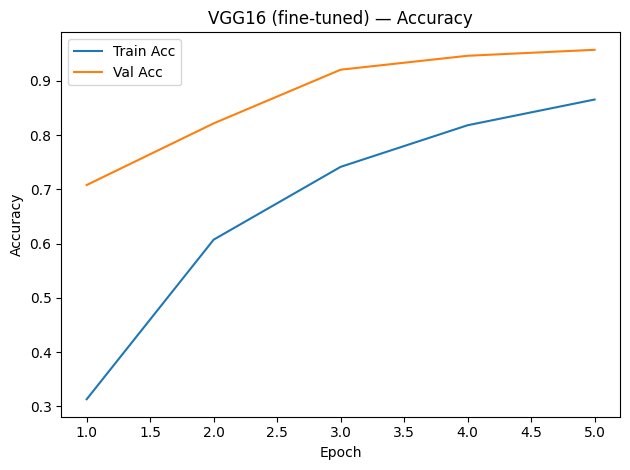

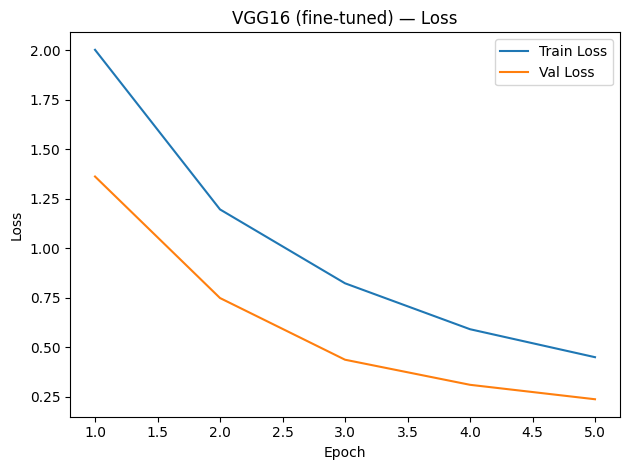

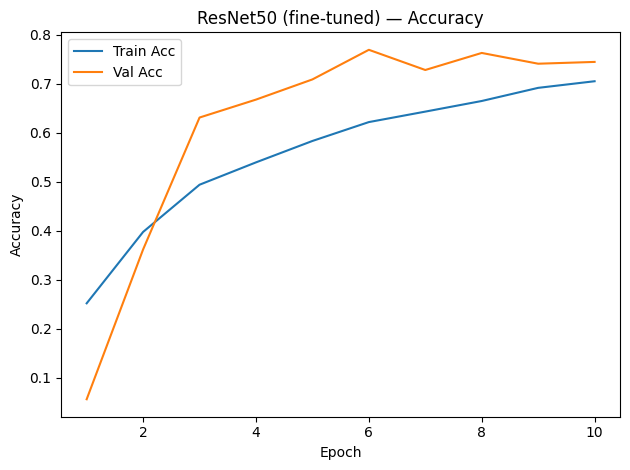

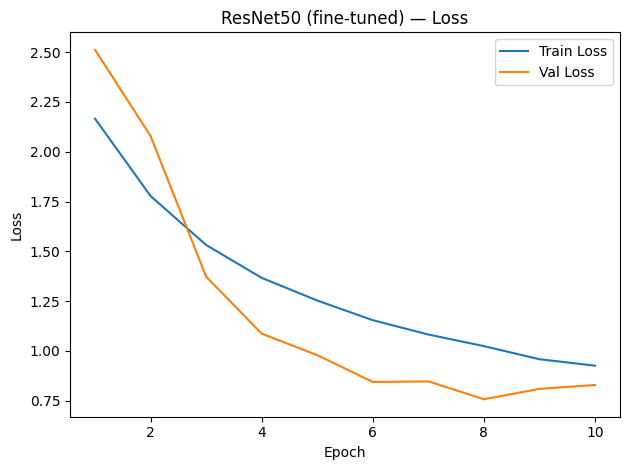

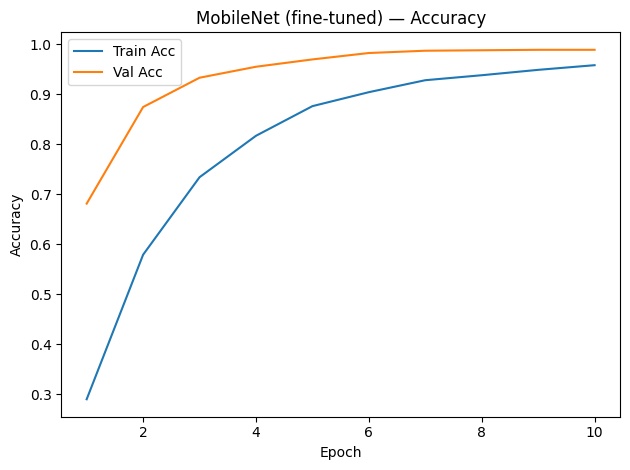

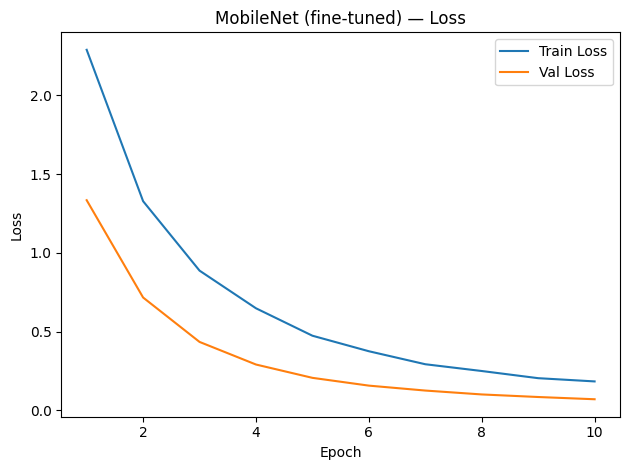

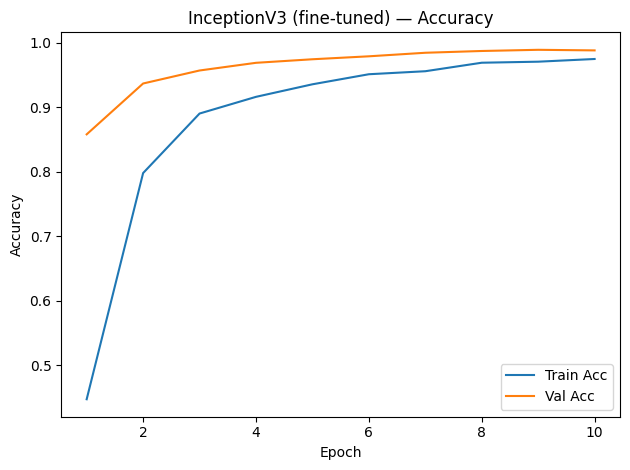

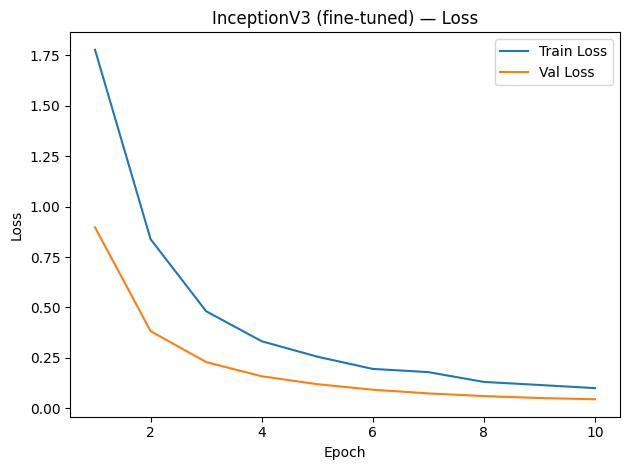

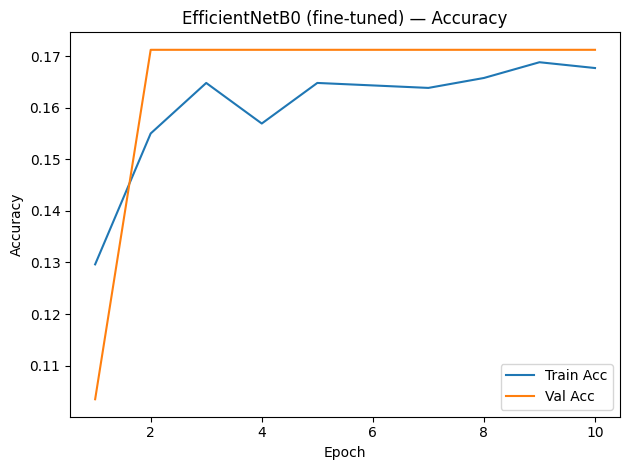

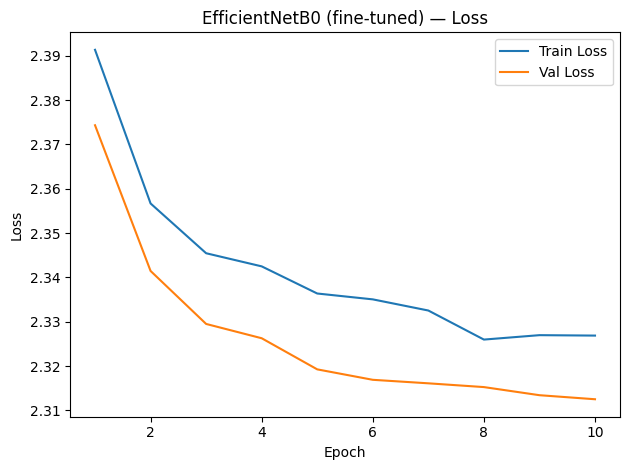

In [56]:
# Iterate through each model
for title, h in histories:
    acc     = _get(h, "accuracy", "acc")
    val_acc = _get(h, "val_accuracy", "val_acc")
    loss    = h.history.get("loss")
    val_loss= h.history.get("val_loss")
    epochs  = range(1, len(loss)+1) if loss else range(1, len(acc)+1)

    # Plot Accuracy
    plt.figure()
    if acc:     plt.plot(epochs, acc, label="Train Acc")
    if val_acc: plt.plot(epochs, val_acc, label="Val Acc")
    plt.title(f"{title} — Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Plot Loss
    plt.figure()
    if loss:     plt.plot(epochs, loss, label="Train Loss")
    if val_loss: plt.plot(epochs, val_loss, label="Val Loss")
    plt.title(f"{title} — Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()